# Data Engineer Assistant

## Load the required libraries

In [46]:
import io
import os
import time
import json
from PIL import Image
from pathlib import Path
from typing import Iterable

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta.threads import Run
from openai.types.beta.threads.messages import MessageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile

## Load the environment variables

In [47]:
load_dotenv()

api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
model_deployment_name = os.getenv("OPENAI_MODEL_DEPLOYMENT")

## Create an AzureOpenAI client

In [48]:
client = AzureOpenAI(
    api_key=api_key,
    azure_endpoint=api_endpoint,
    api_version="2024-01-01-preview"
)

## Create Table in Databricks UC

In [49]:
def create_databricks_table(table_schema: str, table_name: str) -> None:
    # Call the API to create a table
    print("table_schema:", table_schema, "table_name:", table_name)

## Define the Assistant tools

In [50]:
tools_list = [
    {
        "type": "code_interpreter"
    },
    {
        "type": "function",
        "function": {
            "name": "create_databricks_table",
            "description": "Extract information from a CSV file and create a Databricks UC Table.",
            "parameters": {
                "type": "object",
                "properties": {
                    "table_schema": {
                        "type": "string",
                        "enum": ["energy", "HR"],
                        "description": "The table schema on Databricks UC."
                    },
                    "table_name": {
                        "type": "string",
                        "description": "The table name on Databricks UC."
                    }
                },
                "required": ["table_schema", "table_name"]
            },
        },
    }
]

## Upload the data

In [51]:
with Path("../data/turbines.csv").open("rb") as f:
    assistants_file = client.files.create(file=f, purpose="assistants")

file_ids = [assistants_file.id]

## Create an Assistant and a Thread

In [52]:
instructions = """
You are a data engineering assistant skilled in data analysis, capable of aggregating relevant information from CSV files and providing insights.
You are also proficient in Databricks and assist in creating Databricks UC Tables with the data.
"""
instructions += r"\n請使用繁體中文回答"

assistant = client.beta.assistants.create(
  name="Data Engineer Assistant",
  instructions=instructions,
  tools=tools_list,
  model=model_deployment_name,
  file_ids=file_ids
)

thread = client.beta.threads.create()

## Process Function calling

In [53]:
def call_functions(client: AzureOpenAI, thread: Thread, run: Run) -> None:
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    tool_outputs = []

    for action in required_actions["tool_calls"]:
        func_name = action["function"]["name"]
        arguments = json.loads(action["function"]["arguments"])

        if func_name == "create_databricks_table":
            create_databricks_table(
                table_schema=arguments["table_schema"], 
                table_name=arguments["table_name"]
            )
            tool_outputs.append(
                {
                    "tool_call_id": action["id"], 
                    "output": "The table has been created successfully."
                }
            )
        else:
            raise ValueError(f"Unknown function: {func_name}")

    client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs)

## Format and display the Assistant Messages for text and images

In [54]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    message_list.reverse()

    for message in message_list:
        for item in message.content:
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                display(image)

## Process the user messages

In [55]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        elif run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        elif run.status == "expired":
            # Handle expired
            break
        elif run.status == "cancelled":
            # Handle cancelled
            break
        elif run.status == "requires_action":
            call_functions(client, thread, run)
        else:
            time.sleep(5)

## Have a conversation with the Assistant

In [56]:
process_message("What kind of data is this?")

processing...
user:
What kind of data is this?

assistant:
這份數據是有關風力發電機的維護記錄。數據包含了以下幾個欄位：

1. `Turbine_ID`: 風力發電機的識別碼，整數型態。
2. `Wind_Speed`: 風速，整數型態。
3. `RPM`: 每分鐘轉速，整數型態。
4. `Voltage`: 電壓，整數型態。
5. `Maintenance_Date`: 維護日期，字串型態。

這份數據記錄了21筆風力發電機的維護資訊。



processing...
user:
Provide me with a beautiful analytical chart.



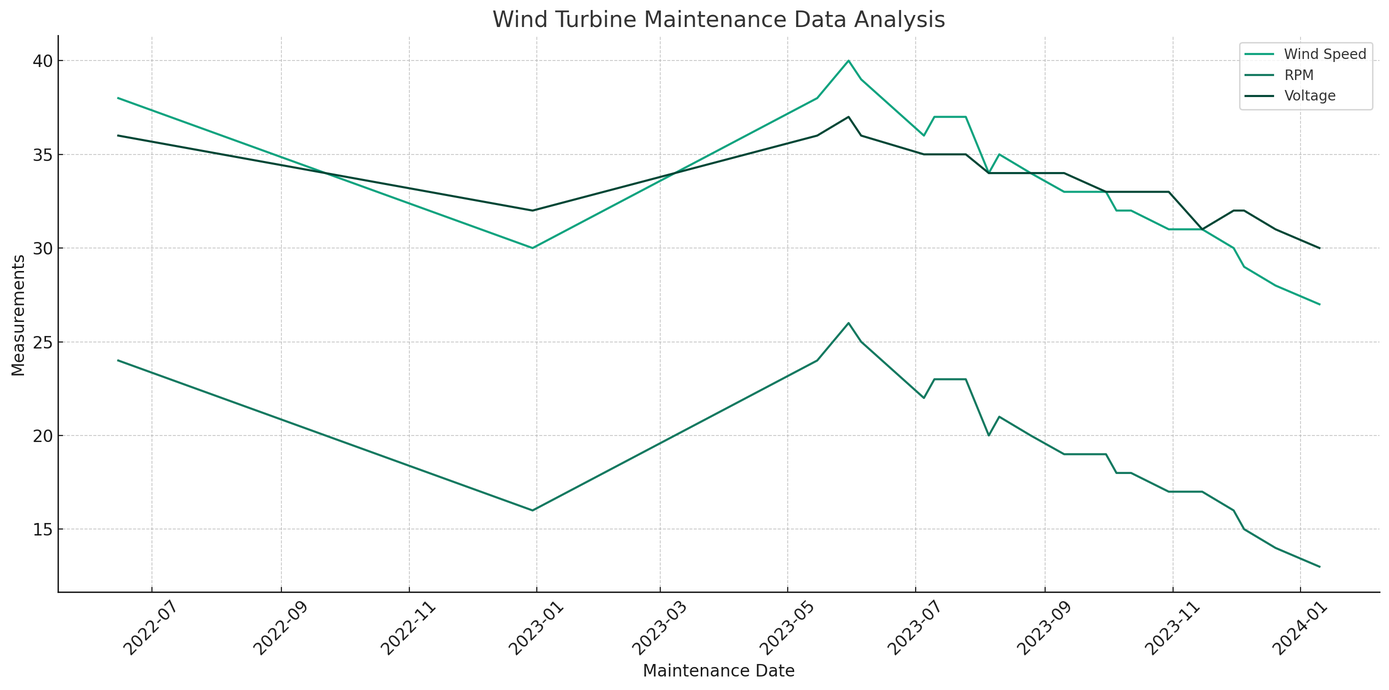

assistant:
這是一張風力發電機維護數據的分析圖。圖中展示了風速、轉速(RPM)和電壓隨著維護日期的變化趨勢。不同的測量指標以彩色線條表示，而維護日期則在x軸上顯示。從圖中可以觀察到各項指標的變化情況，這有助於分析風力發電機在維護期間的表現。



In [57]:
process_message("Provide me with a beautiful analytical chart.")

In [58]:
# Function Calling
process_message("Please create a Databricks table from the data in the energy schema.")

processing...
table_schema: energy table_name: wind_turbine_maintenance
user:
Please create a Databricks table from the data in the energy schema.

assistant:
已成功在 Databricks 中創建了一個名為 `wind_turbine_maintenance` 的表格，它使用 `energy` 架構。



In [59]:
# Code Interpreter
process_message("Use PySpark to query this table.")

processing...
user:
Use PySpark to query this table.

assistant:
要使用 PySpark 查询 Databricks 中的 `wind_turbine_maintenance` 表格，你需要首先安装和配置 PySpark，在 Databricks 环境中通常已经配置好了。以下是一个示例 PySpark 查询：

```python
from pyspark.sql import SparkSession

# 创建 Spark 会话
spark = SparkSession.builder.appName("wind_turbine_maintenance_query").getOrCreate()

# 将 Databricks 表加载为 DataFrame
df = spark.table("wind_turbine_maintenance")

# 显示 DataFrame 的内容
df.show()

# 关闭 Spark 会话
spark.stop()
```

这段代码会启动一个 PySpark 会话，加载指定的表为一个 DataFrame，然后显示其内容。结束后关闭 PySpark 会话。在实际的 Databricks 环境中, `spark` 会话对象通常已经预创建好，所以你通常不需要手动创建它。

如果你需要执行特定的查询操作，比如选择特定列，过滤数据，或者进行聚合，你可以使用 PySpark 提供的 DataFrame API 调用对应的方法。例如：

```python
# 查询特定的列
df.select("Turbine_ID", "Wind_Speed").show()

# 根据某个条件过滤数据
df.filter(df["Voltage"] > 34).show()

# 对数据进行聚合操作
df.groupBy("Turbine_ID").avg("Wind_Speed").show()
```

以上示例显示了如何选取列、根据条件过滤以及如何聚合数据。在具体应用中，根据你的需求选择不同的数据操作函数。

由于我目前在这个环境中不能实际连接到你的 Databricks 环境，你需要在你有权限的 Databricks 环境中执行以上查询。如果需要帮助构建特定查询的代码，请

## Cleanup

In [60]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)

for file_id in file_ids:
    client.files.delete(file_id)